In [2]:
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt












In [3]:
# Cell 1: User Input Cell
m1 = 1.0
m2 = 1.0
x1_0 = np.array([-1.0, 0.0])
x2_0 = np.array([1.0, 0.0])
v1_0 = np.array([0.0, 0.5])
v2_0 = np.array([0.0, -0.5])
G = 1.0
t_input = 5.0

print(f"System: m1={m1}, m2={m2}, x1_0={x1_0}, x2_0={x2_0}, v1_0={v1_0}, v2_0={v2_0}")
print(f"Prediction time t={t_input}")


System: m1=1.0, m2=1.0, x1_0=[-1.  0.], x2_0=[1. 0.], v1_0=[0.  0.5], v2_0=[ 0.  -0.5]
Prediction time t=5.0


In [4]:
# Cell 2: Data Generation
def derivatives(t, y):
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = y
    dx = x2 - x1
    dy = y2 - y1
    r = np.sqrt(dx**2 + dy**2) + 1e-8
    ax1 = G * m2 * dx / r**3
    ay1 = G * m2 * dy / r**3
    ax2 = G * m1 * (-dx) / r**3
    ay2 = G * m1 * (-dy) / r**3
    return [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2]

y0 = np.concatenate([x1_0, v1_0, x2_0, v2_0])
t_span = (0, 10)
t = np.linspace(0, 10, 100)
sol = solve_ivp(derivatives, t_span, y0, method='RK45', t_eval=t)
positions = sol.y[[0, 1, 4, 5], :].T

t_train, t_test, pos_train, pos_test = train_test_split(t, positions, test_size=0.2, random_state=42)
t_train = torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)
t_test = torch.tensor(t_test, dtype=torch.float32).reshape(-1, 1)
pos_train = torch.tensor(pos_train, dtype=torch.float32)
pos_test = torch.tensor(pos_test, dtype=torch.float32)

print(f"Generated {len(t)} data points, split into {len(t_train)} train and {len(t_test)} test samples")

Generated 100 data points, split into 80 train and 20 test samples


In [5]:
# Cell 3: Model Definition
class PlanetMotionNN(nn.Module):
    def __init__(self):
        super(PlanetMotionNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
    
    def forward(self, t):
        return self.net(t)

model = PlanetMotionNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

In [6]:
# Cell 4: Training
def compute_ode_residuals(t, model, m1, m2, G):
    t = t.clone().requires_grad_(True)
    x_pred = model(t)
    dx_dt = torch.zeros_like(x_pred)
    d2x_dt2 = torch.zeros_like(x_pred)
    
    for j in range(t.shape[0]):
        t_j = t[j:j+1].clone().requires_grad_(True)
        x_pred_j = model(t_j)
        if not x_pred_j.requires_grad:
            raise RuntimeError("x_pred_j does not require grad")
        for i in range(4):
            grad_output = torch.ones_like(x_pred_j[0, i])
            dx_dt_j_i = torch.autograd.grad(
                x_pred_j[0, i], t_j, grad_outputs=grad_output,
                create_graph=True, retain_graph=True
            )[0]
            if dx_dt_j_i is None:
                raise RuntimeError(f"Gradient for x_pred_j[0, {i}] is None")
            if not dx_dt_j_i.requires_grad:
                raise RuntimeError(f"dx_dt_j_i for output {i} does not require grad")
            dx_dt[j, i] = dx_dt_j_i[0, 0]
            d2x_dt2_j_i = torch.autograd.grad(
                dx_dt_j_i, t_j, grad_outputs=torch.ones_like(dx_dt_j_i),
                create_graph=True, retain_graph=True
            )[0]
            if d2x_dt2_j_i is None:
                raise RuntimeError(f"Second gradient for x_pred_j[0, {i}] is None")
            d2x_dt2[j, i] = d2x_dt2_j_i[0, 0]
    
    x1_pred = x_pred[:, 0:2]
    x2_pred = x_pred[:, 2:4]
    dx = x2_pred - x1_pred
    r = torch.norm(dx, dim=1, keepdim=True) + 1e-8
    expected_d2x1_dt2 = G * m2 * dx / r**3
    expected_d2x2_dt2 = G * m1 * (-dx) / r**3
    expected_d2x_dt2 = torch.cat((expected_d2x1_dt2, expected_d2x2_dt2), dim=1)
    
    residuals = d2x_dt2 - expected_d2x_dt2
    return torch.mean(residuals**2)

num_epochs = 1000
lambda_ode = 1.0
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    pred_train = model(t_train)
    data_loss = mse_loss(pred_train, pos_train)
    ode_loss = compute_ode_residuals(t_train, model, m1, m2, G)
    total_loss = data_loss + lambda_ode * ode_loss
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Data Loss: {data_loss.item():.4f}, ODE Loss: {ode_loss.item():.4f}")

Epoch [100/1000], Data Loss: 0.7695, ODE Loss: 0.2576
Epoch [200/1000], Data Loss: 0.6802, ODE Loss: 0.2074
Epoch [300/1000], Data Loss: 0.6378, ODE Loss: 0.1862
Epoch [400/1000], Data Loss: 0.6201, ODE Loss: 0.1680
Epoch [500/1000], Data Loss: 0.6086, ODE Loss: 0.1539
Epoch [600/1000], Data Loss: 0.5969, ODE Loss: 0.1439
Epoch [700/1000], Data Loss: 0.5823, ODE Loss: 0.1367
Epoch [800/1000], Data Loss: 0.5627, ODE Loss: 0.1316
Epoch [900/1000], Data Loss: 0.5365, ODE Loss: 0.1274
Epoch [1000/1000], Data Loss: 0.4927, ODE Loss: 0.1201


In [7]:
# Cell 5: Evaluation Criteria
model.eval()
with torch.no_grad():
    pred_test = model(t_test)
mae = torch.mean(torch.abs(pred_test - pos_test))
t_test_grad = t_test.clone().requires_grad_(True)
ode_residual = compute_ode_residuals(t_test_grad, model, m1, m2, G)

print(f"MAE on test set: {mae.item():.4f}")
print(f"Mean ODE residual on test set: {ode_residual.item():.4f}")

MAE on test set: 0.6036
Mean ODE residual on test set: 0.1336


Predicted position at t=5.0:
x1(t) = [ 0.8787081 -0.0547431]
x2(t) = [-0.6864287   0.17574435]
Trajectory plot saved as 'trajectories.png'


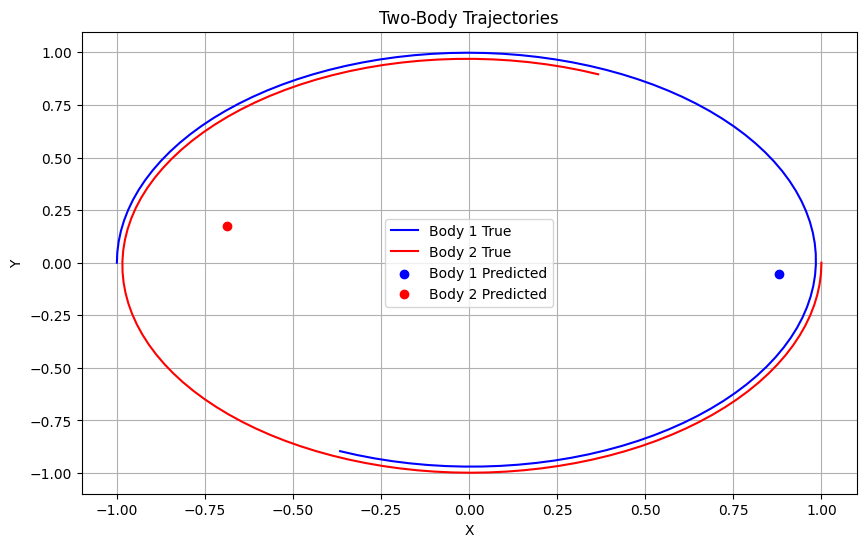

In [8]:
# Cell 6: Final Model Performance (Prediction)
t_pred = torch.tensor([[t_input]], dtype=torch.float32)
with torch.no_grad():
    pred_positions = model(t_pred)
    x1_t = pred_positions[0, 0:2].numpy()
    x2_t = pred_positions[0, 2:4].numpy()

print(f"Predicted position at t={t_input}:")
print(f"x1(t) = {x1_t}")
print(f"x2(t) = {x2_t}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], 'b-', label='Body 1 True')
plt.plot(positions[:, 2], positions[:, 3], 'r-', label='Body 2 True')
plt.scatter(x1_t[0], x1_t[1], c='blue', label='Body 1 Predicted')
plt.scatter(x2_t[0], x2_t[1], c='red', label='Body 2 Predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Two-Body Trajectories')
plt.grid(True)
plt.savefig('trajectories.png')
print("Trajectory plot saved as 'trajectories.png'")